In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.data_processing import (
    load_dataset, 
    save_dataset,
    remove_duplicates_and_empty_rows,
    check_if_column_is_unique_per_row,
    predict_missing_values_with_linear_regression,
    get_outliers_IRQ,
    get_distinct_rows_from_dataframes,
    BRONZE_PATH,
    SILVER_PATH,
    GROUP_FILENAME,
    POSTS_FILENAME
)
from utils.data_visualization import (
    analyse_categorical_features,
    analyse_numerical_features,
    analyse_numerical_features_per_category,
    plot_correlation_matrices,
    plot_scatter_graph,
    analyse_aggregated_features_per_category
)

In [2]:
posts_df = load_dataset(SILVER_PATH + "posts_and_group", "parquet")

# Features Engineering:

In this section additional metrics based on preprocessed _silver_ data will be defined and analysed. Enriched dataset and used aggregated tables would be saved to _gold_ layer as data ready for predictive analysis.

Main purposes of new metrics are to mirrow and help to descide how to:
- Increase the overall `reach` of publications.
- Increase the overall `reactions` with publications.
- Increate total `share` of publications.

We will define the following additional metrics based on existing features:
1. **Post day of week:** find out whether `reach` to posts is affected by day of week, as user activity obviously may vary depending on it.
2. **Reach-to-Engagement Ratio:** measure of how "interesting" the post is and how actively users interact with it. It will help us to define categories, wich which users interacts the most as well as a general trend of user engagement.
3. **Post Interest Rate:** categorical interpretation of the feature above, where $<10 \%$, $<50\%$, $\geq 50\%$ _Reach-to-Engagement Ratio_ will define _low_, _medium_, and _high_ post interest respectively. 
4. **Qnique reaches:** if we count that each `share` of the post brought exactly one `reach`, this metric indicates how many users found this post by themselves. It could help us to define where it is necessary to produce more posts, and where to increase a number of users sharing this post.

This notebook consists of the following parts:
1. Metrics creation.
2. Metrics dependency on `post_day_of_week`.
3. Metrics dependency on `post_interest_rate`.
4. Conclusion.

## 1. Metrics creation:

Creating metrics for `posts_df`:

In [3]:
posts_df['post_day_of_week'] = posts_df["post_date"].dt.day_name()
posts_df['post_day_of_week'].describe()

count       20000
unique          7
top       Tuesday
freq         2897
Name: post_day_of_week, dtype: object

In [4]:
posts_df['engagement_to_reach'] = (
    (posts_df['likes'] + posts_df['comments'] + posts_df['share'] + posts_df['click']) / posts_df["reach"]
)
posts_df['engagement_to_reach'].describe()

count    20000.000000
mean         0.310754
std          0.507941
min          0.000109
25%          0.110713
50%          0.164397
75%          0.282882
max          7.450980
Name: engagement_to_reach, dtype: float64

In [5]:
bins = [0, 0.1, 0.5, 100]
labels = ['low', 'medium', 'high']

posts_df['post_interest_rate'] = pd.cut(posts_df['engagement_to_reach'], bins=bins, labels=labels, right=False)
posts_df['post_interest_rate'].describe()

count      20000
unique         3
top       medium
freq       13586
Name: post_interest_rate, dtype: object

In [6]:
posts_df['unique_reach'] = (
    posts_df['reach'] - posts_df['share']
)

posts_df['unique_reach'].describe()

count     20000.000000
mean     104660.872600
std      239586.818792
min         -41.000000
25%         874.750000
50%        3812.000000
75%        8744.250000
max      999711.000000
Name: unique_reach, dtype: float64

## 2. Metrics dependency on `post_day_of_week`:

### Aggregated graphichs:

Graphics displaying how total amount of `reach` and engagement metrics vary depending on the `post_day_of_the_week` aggregated and by `post_type`.

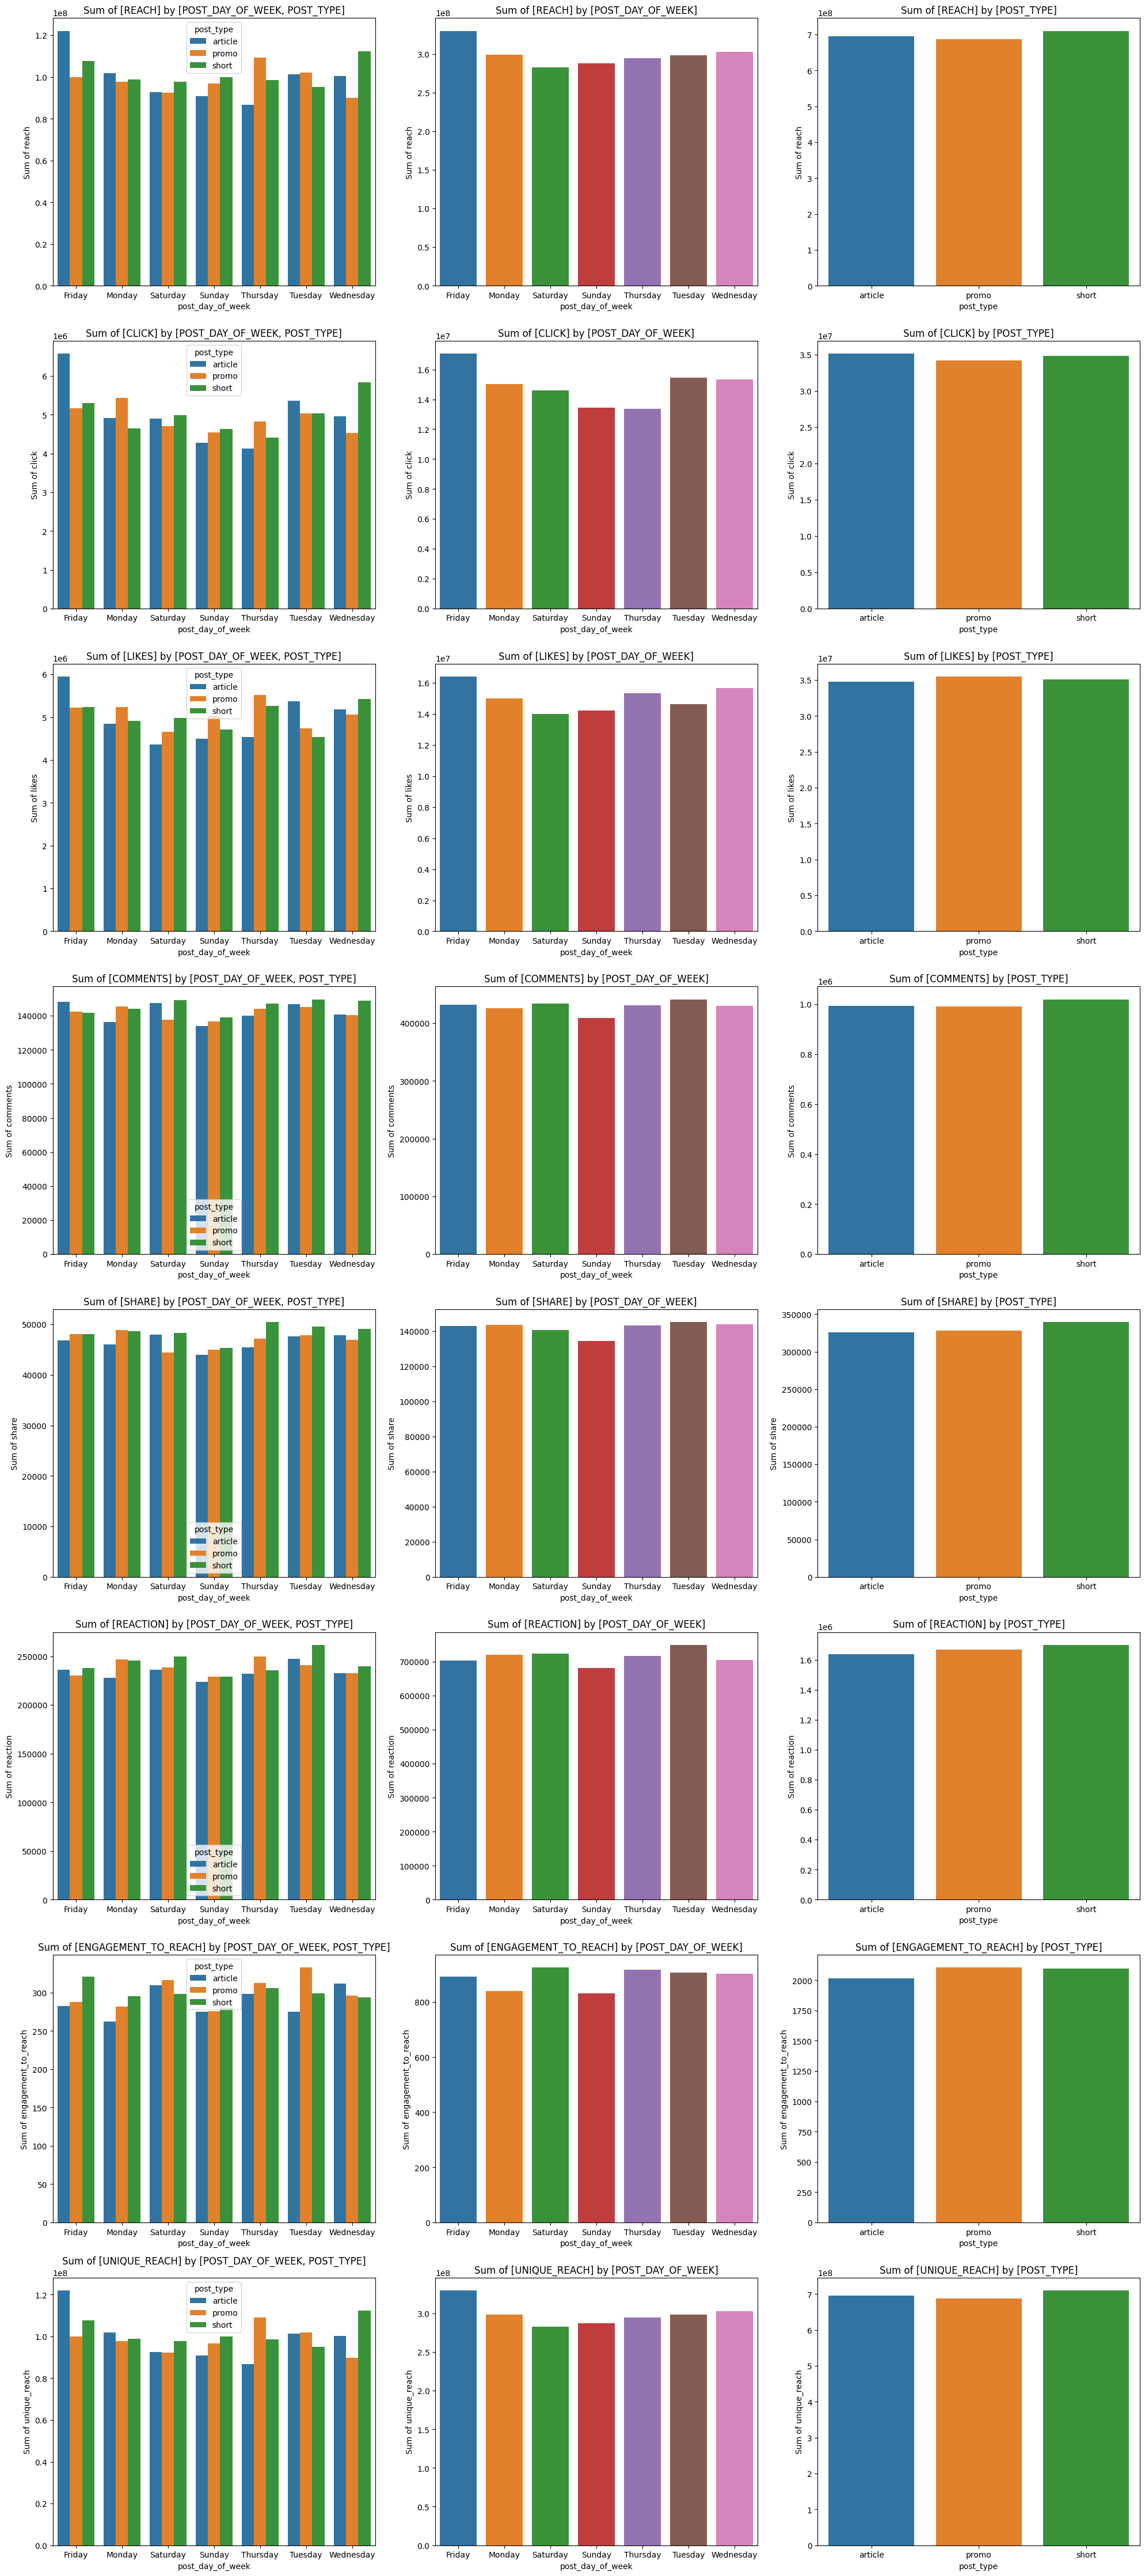

In [7]:
analyse_aggregated_features_per_category(
    posts_df, 
    agg_cols=[['post_day_of_week', 'post_type'], ['post_day_of_week'], ['post_type']],
    metrics=['reach', 'click', 'likes', 'comments', 'share', 'reaction', 'engagement_to_reach', 'unique_reach']
)

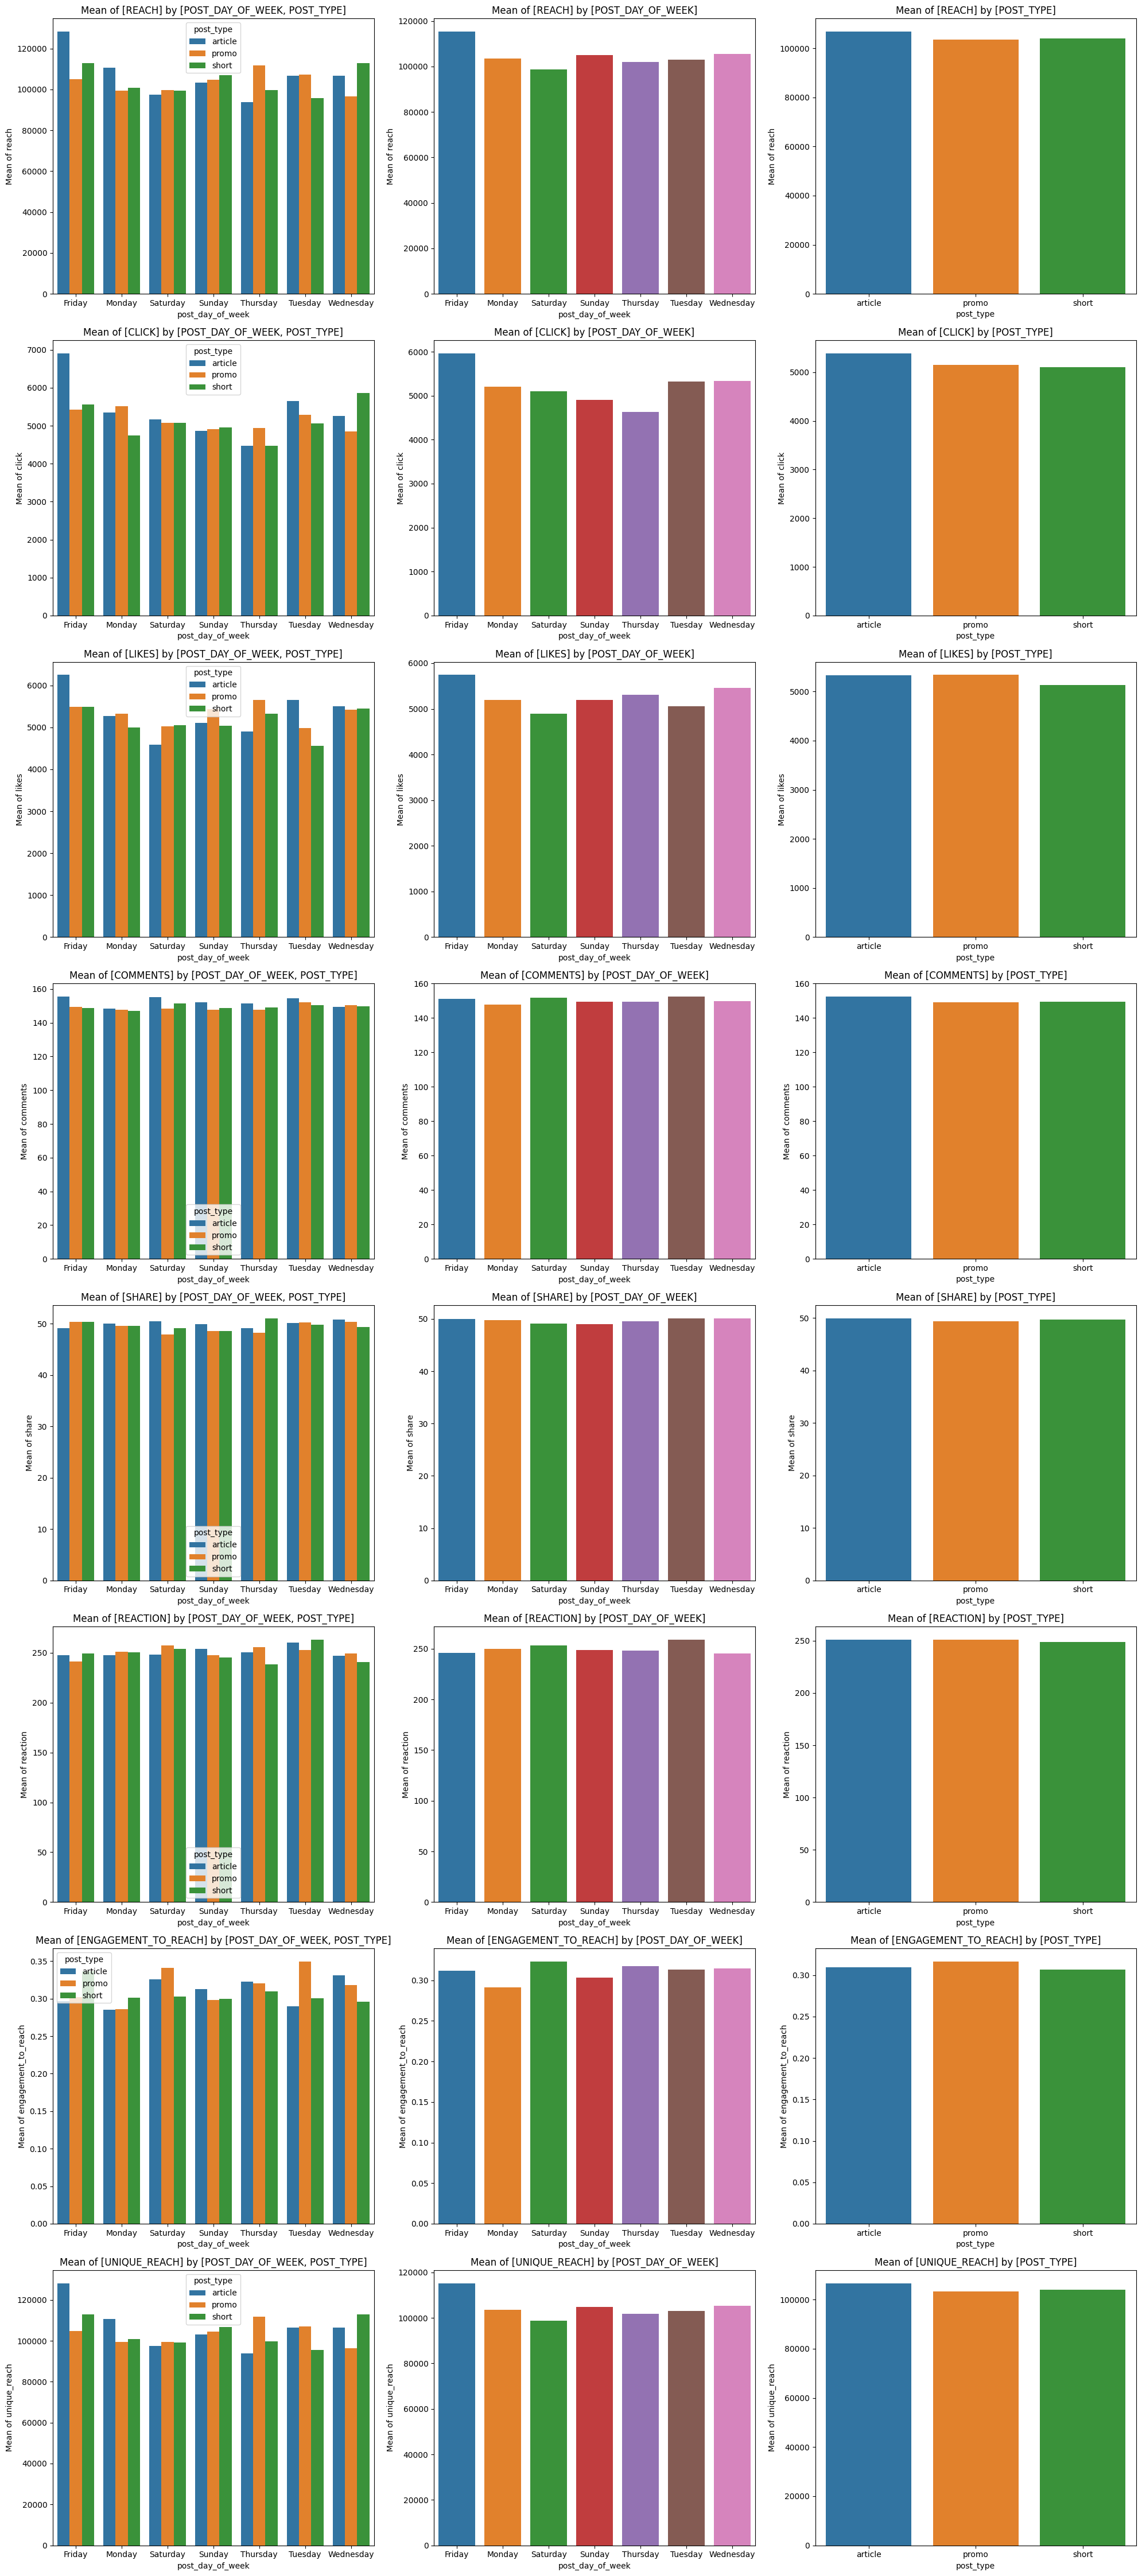

In [8]:
analyse_aggregated_features_per_category(
    posts_df, 
    agg_cols=[['post_day_of_week', 'post_type'], ['post_day_of_week'], ['post_type']],
    metrics=['reach', 'click', 'likes', 'comments', 'share', 'reaction', 'engagement_to_reach', 'unique_reach'],
    agg_method='mean'
)

As we can see, for `post_type = 'article'` metrics `reach`, `click`, `likes`, `unique_reach` are higher than for other days.

In total average increase of this metric for this `post_type` on Fridays are:

In [9]:
target_metrics = ['reach', 'click', 'likes', 'unique_reach']

df = posts_df[posts_df['post_type'] == 'article'][target_metrics + ['post_day_of_week']].groupby('post_day_of_week').mean()
df

,reach,click,likes,unique_reach
post_day_of_week,,,,
Friday,128233.847689,6909.323529,6249.949580,128184.686975
Monday,110741.715217,5346.191304,5270.971739,110691.698913
Saturday,97474.208421,5164.693684,4587.148421,97423.781053
Sunday,103225.989773,4859.406818,5110.484091,103176.062500
Thursday,93779.618378,4469.259459,4900.381622,93730.509189
Tuesday,106647.986316,5646.474737,5655.397895,106597.854737
Wednesday,106588.536093,5261.975584,5503.102972,106537.783439


In [19]:
results = {}
for column in df.columns:
    results[column + '_percentage_less_than_FR'] = {}
    friday_value = df.loc['Friday', column]
    for i in range(1, len(df)):
        results[column + '_percentage_less_than_FR'][df.index[i]] = 100 - df.loc[df.index[i], column] / friday_value * 100
    results[column + '_percentage_less_than_FR']['Friday'] = 0.0

percentage_differ_per_day_of_week_df = pd.DataFrame(results)
percentage_differ_per_day_of_week_df.T

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Friday
reach_percentage_less_than_FR,13.640808,23.987145,19.501761,26.868280,16.833201,16.879562,0.0
click_percentage_less_than_FR,22.623520,25.250371,29.668848,35.315528,18.277459,23.842391,0.0
likes_percentage_less_than_FR,15.663772,26.605033,18.231595,21.593262,9.512904,11.949642,0.0
unique_reach_percentage_less_than_FR,13.646707,23.997333,19.509838,26.878544,16.840414,16.887277,0.0


### Conclusion:

To sum up, we see that in general for articles metrics `['reach', 'click', 'likes', 'unique_reach']` on Friday are increasing from ~15% to ~25%. 

In this case a general proposal will be to increase a number of articles published on Fridays, since users are more engaged to click and like this content on the day mentioned. For the sake of resource saving, proposition would be to reschedule publishing of articles from other days of week to Friday.

## 3. Metrics dependency on `post_interest_rate`:

### Aggregated graphics:

Graphics displaying how total amount of `reach` and engagement metrics vary depending on the `post_interest_rate` aggregated and by `post_type`.

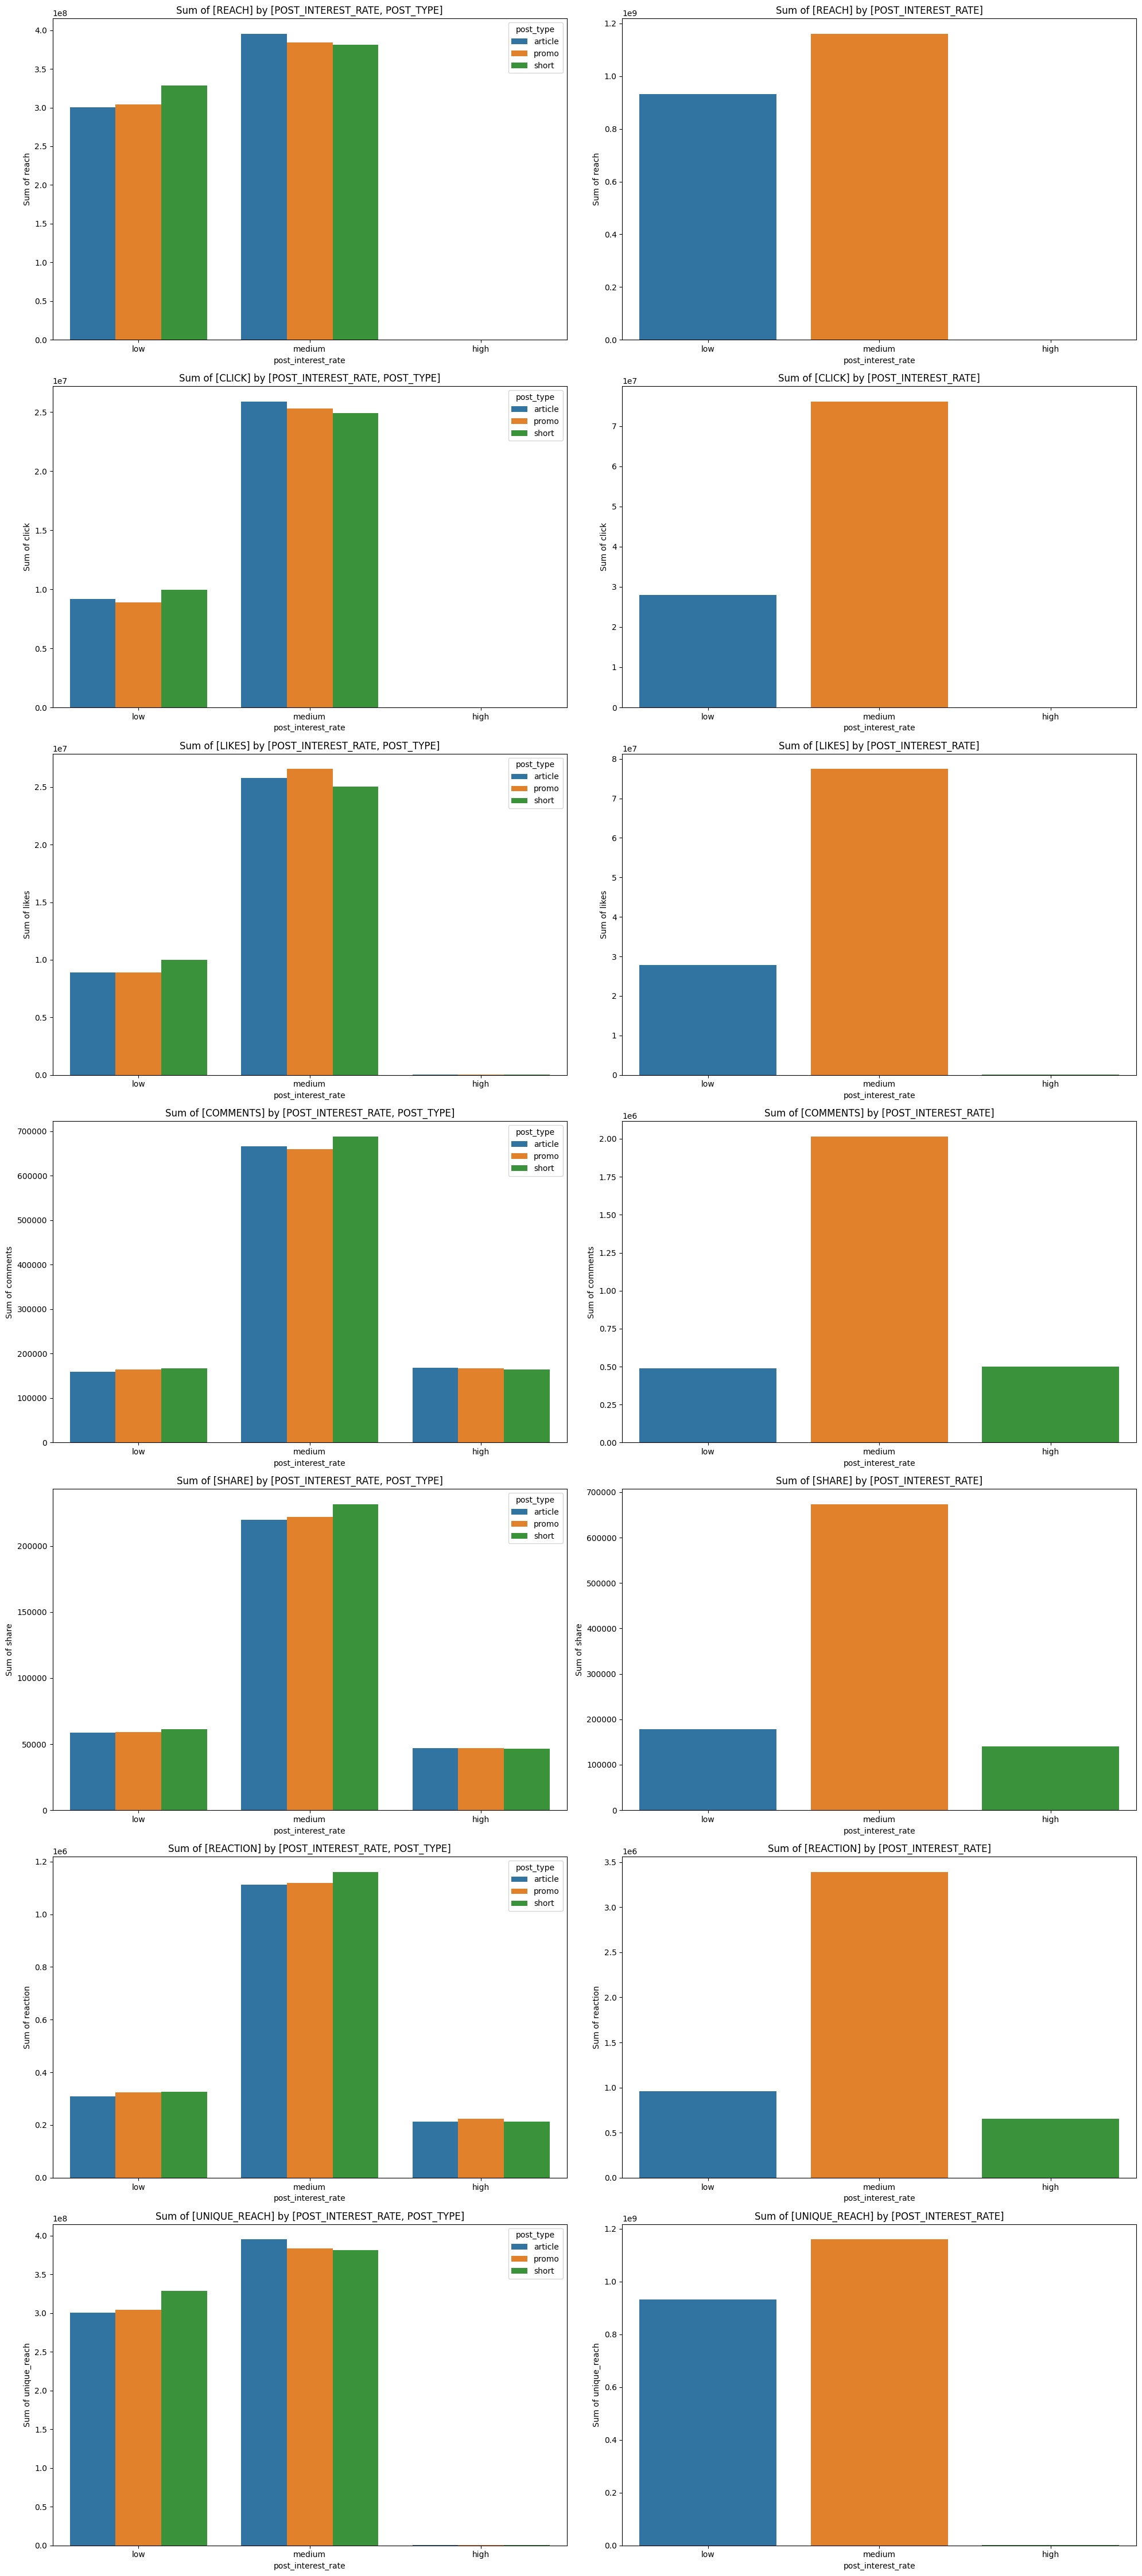

In [14]:
analyse_aggregated_features_per_category(
    posts_df, 
    agg_cols=[['post_interest_rate', 'post_type'], ['post_interest_rate']],
    metrics=['reach', 'click', 'likes', 'comments', 'share', 'reaction', 'unique_reach'],
    agg_method='sum'
)

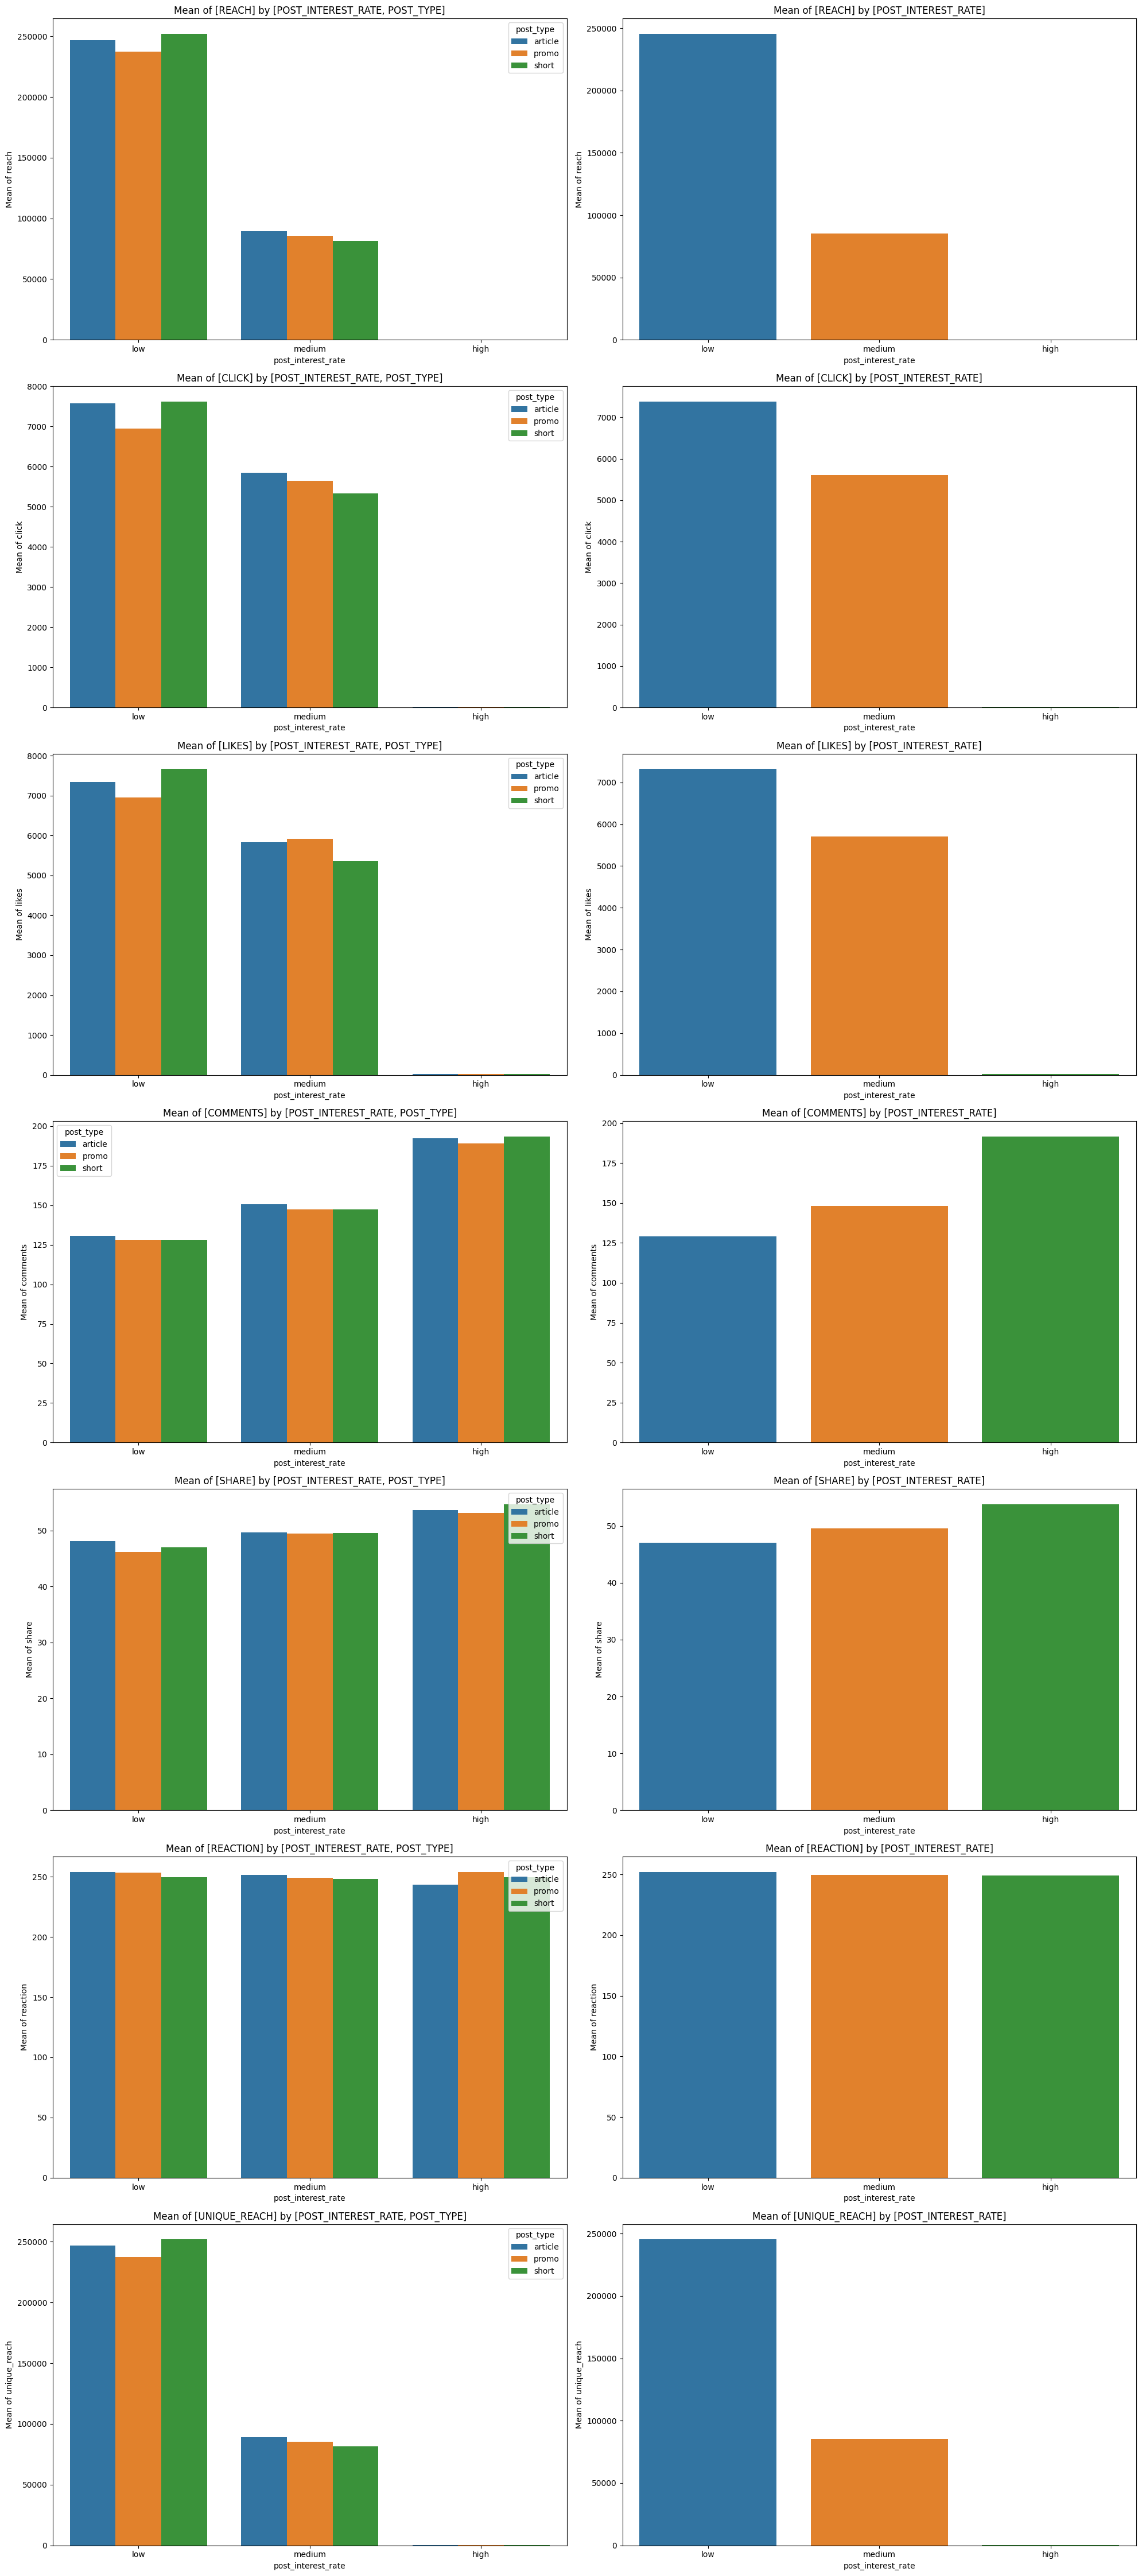

In [15]:
analyse_aggregated_features_per_category(
    posts_df, 
    agg_cols=[['post_interest_rate', 'post_type'], ['post_interest_rate']],
    metrics=['reach', 'click', 'likes', 'comments', 'share', 'reaction', 'unique_reach'],
    agg_method='mean'
)

Graphics displaying how total amount of `reach` and engagement metrics vary depending on the `post_interest_rate` aggregated and by `post_day_of_week`.

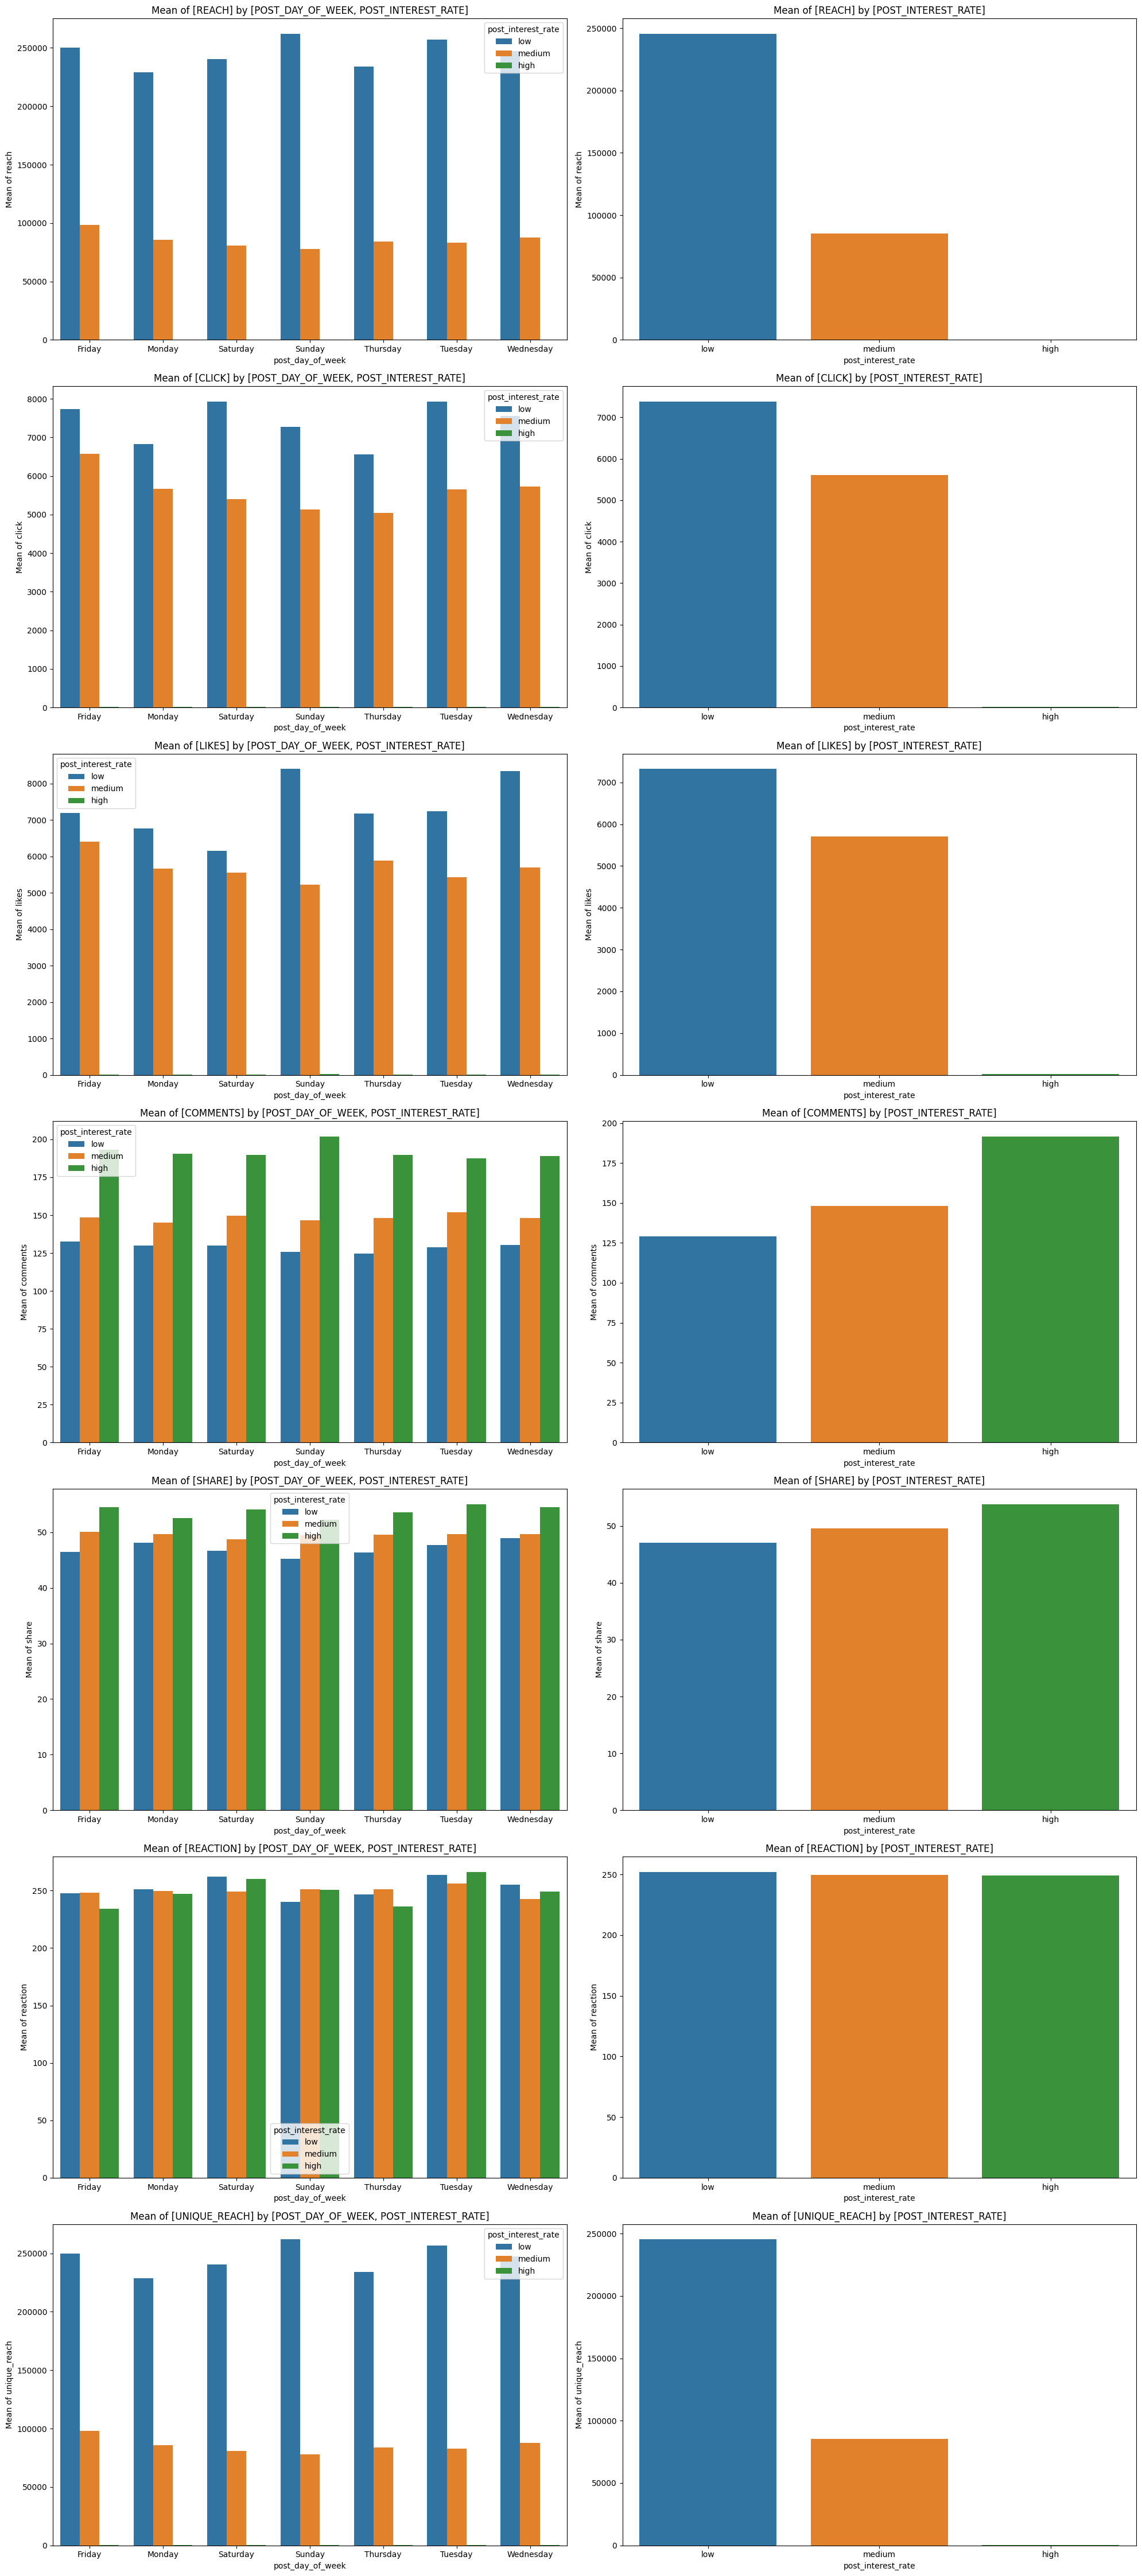

In [20]:
analyse_aggregated_features_per_category(
    posts_df, 
    agg_cols=[['post_day_of_week', 'post_interest_rate'], ['post_interest_rate']],
    metrics=['reach', 'click', 'likes', 'comments', 'share', 'reaction', 'unique_reach'],
    agg_method='mean'
)

### Conclusion:

From the graphs above we can make the following conclusions:
- `share` and `comment` metrics are visible only for posts with extremely high popularity (any comment produces a reply).
- `unique_reach`, `reach`, `likes` metrics average for unpopular `post_type = 'article'` is relatively higher than for more popular posts. One can fairly suppose that articles are less resonant than popular posts of other types, however they "produce clicks" via click-beat titles and likes as a way of safe interesting material.
- Difference between post interest and other metrics does not vary a lot through the days of the week.
- `reaction` is high for medium posts. Popularity of `post_interest_rate = 'high'` are made through `comment` and `share`.

General proposals for achieving defined goals are:
1. Add a note / mechanism for articles to save it through reaction or like.
2. Add notes / mechanisms to engage people to read comments to the popular posts and leave their own, since it is a great way to increase posts statistics whithout necessity to bring more unique viewers.

## 4. PUPUPU [!!!]